**Bước 0:Cài đặt thư viện và import**
- pip install pandas
- pip install numpy
- pip install matplotlib
- pip install scikit-learn (sklearn)
- pip install pickle (nếu lỗi version thì pip install pickle5)
- pip install yfinance (data về chứng khoán)

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

**Bước 1: Đọc DATA và khám phá dữ liệu (Công ty Amazon)**

In [10]:
# Ticker symbol của cổ phiếu bạn muốn dự đoán
ticker_symbol = 'AMZN'

# Lấy dữ liệu lịch sử giá cổ phiếu
stock_data = yf.download(ticker_symbol, start='2003-10-20', end='2024-06-14')

[*********************100%***********************]  1 of 1 completed


In [11]:
stock_data

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN
Date,,,,,,
2003-10-20 00:00:00+00:00,2.979500,2.979500,3.012000,2.946000,2.978000,221722000
2003-10-21 00:00:00+00:00,2.967500,2.967500,3.057500,2.950500,2.986500,342298000
2003-10-22 00:00:00+00:00,2.701500,2.701500,2.807500,2.686500,2.802500,654038000
2003-10-23 00:00:00+00:00,2.716000,2.716000,2.726000,2.645500,2.649000,292234000
2003-10-24 00:00:00+00:00,2.725500,2.725500,2.747000,2.650000,2.727500,208764000
...,...,...,...,...,...,...
2024-06-07 00:00:00+00:00,184.300003,184.300003,186.289993,183.360001,184.899994,28021500
2024-06-10 00:00:00+00:00,187.059998,187.059998,187.229996,183.789993,184.070007,34494500


In [12]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5198 entries, 2003-10-20 00:00:00+00:00 to 2024-06-13 00:00:00+00:00
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, AMZN)  5198 non-null   float64
 1   (Close, AMZN)      5198 non-null   float64
 2   (High, AMZN)       5198 non-null   float64
 3   (Low, AMZN)        5198 non-null   float64
 4   (Open, AMZN)       5198 non-null   float64
 5   (Volume, AMZN)     5198 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 284.3 KB


In [13]:
# Những feature của tập dữ liệu
stock_data.keys()

MultiIndex([('Adj Close', 'AMZN'),
            (    'Close', 'AMZN'),
            (     'High', 'AMZN'),
            (      'Low', 'AMZN'),
            (     'Open', 'AMZN'),
            (   'Volume', 'AMZN')],
           names=['Price', 'Ticker'])

In [14]:
# Thống kê mô tả về tập dữ liệu
description = stock_data.describe()
mode = stock_data.select_dtypes(include=["number"]).mode().iloc[0]
mode.name = "mode"
median = stock_data.select_dtypes(include=["number"]).median()
median.name = "median"
description = description._append(mode)
description = description._append(median)
description

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN
count,5198.000000,5198.000000,5198.000000,5198.000000,5198.000000,5.198000e+03
mean,47.603707,47.603707,48.165190,47.015699,47.613195,1.107481e+08
std,56.190599,56.190599,56.861766,55.511657,56.216182,9.204037e+07
min,1.303500,1.303500,1.315000,1.288000,1.304500,1.762600e+07
25%,4.034500,4.034500,4.111750,3.951875,4.036625,6.004900e+07
50%,15.649000,15.649000,15.837750,15.521500,15.697500,8.874000e+07
75%,89.038626,89.038626,89.835001,88.012873,89.150002,1.339715e+08
max,189.500000,189.500000,191.699997,187.440002,189.160004,2.086584e+09
mode,1.897500,1.897500,1.950000,1.757000,1.675000,5.827200e+07


**Bước 2: Kiểm tra và tiền xử lý dữ liệu(nếu có)**




In [15]:
stock_data.shape
# kích thước dữ liệu

(5198, 6)

In [16]:
stock_data.dtypes
#Kiểu dữ liệu của từng feature

,,0
Price,Ticker,
Adj Close,AMZN,float64
Close,AMZN,float64
High,AMZN,float64
Low,AMZN,float64
Open,AMZN,float64
Volume,AMZN,int64


In [17]:
stock_data.isnull().sum()
#check missing value

,,0
Price,Ticker,
Adj Close,AMZN,0
Close,AMZN,0
High,AMZN,0
Low,AMZN,0
Open,AMZN,0
Volume,AMZN,0


**Ta thấy tập dữ liệu này khá là sạch**

**Vẽ biểu đồ phân tích**

1. Vẽ biểu đồ cột

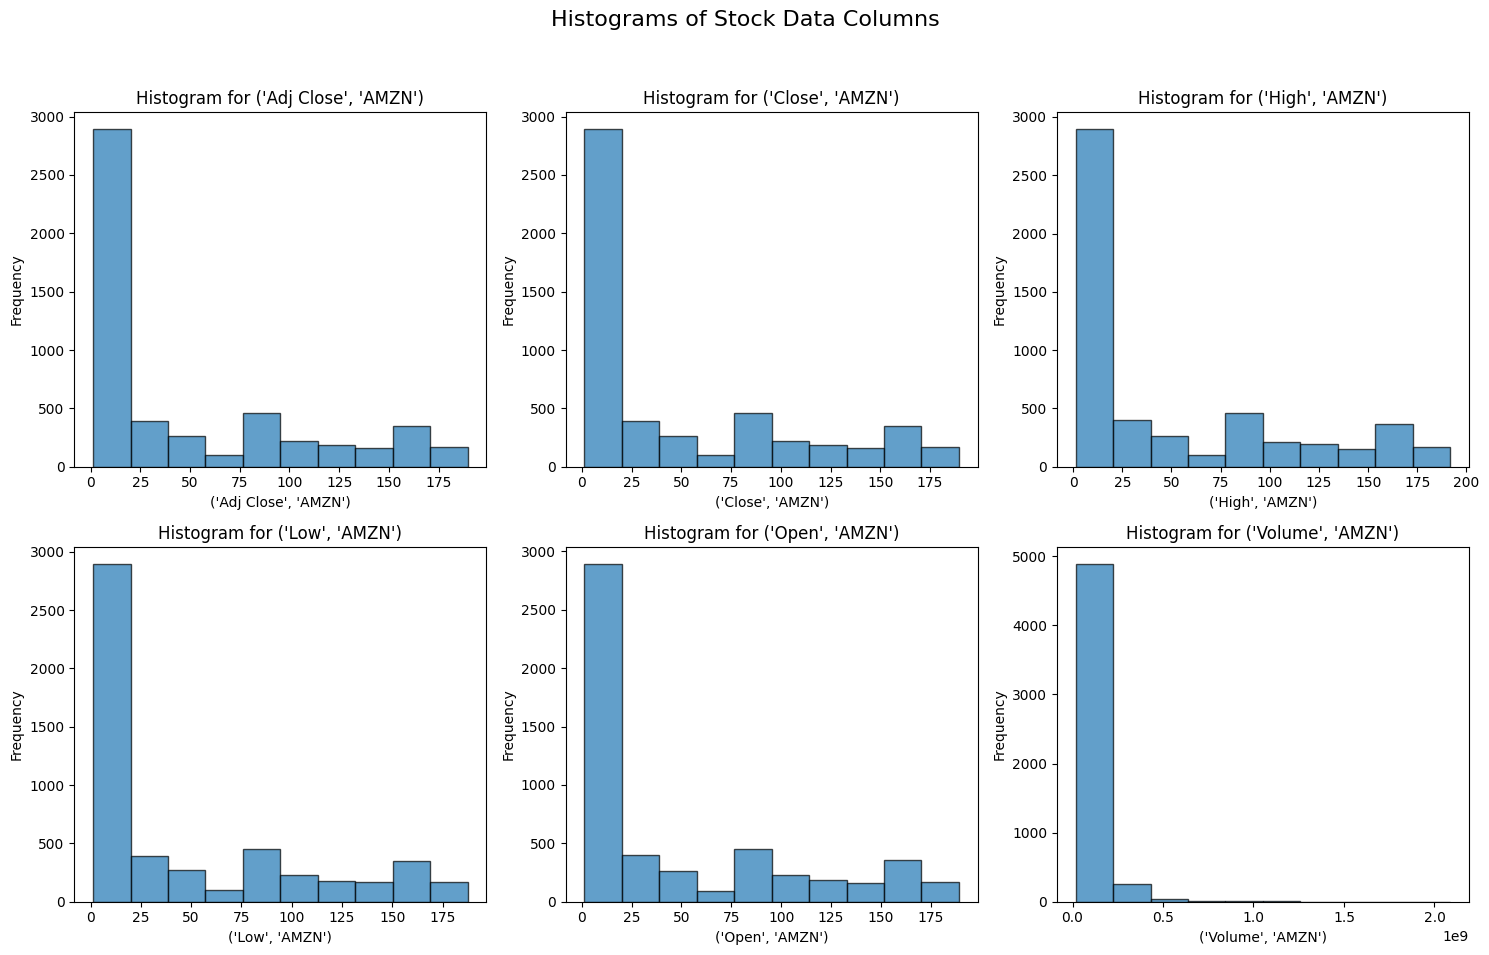

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Giả sử stock_data là DataFrame của bạn
# Đảm bảo bạn đã import thư viện pandas và đã có dữ liệu

# Tạo subplot
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
fig.suptitle('Histograms of Stock Data Columns', fontsize=16)

# Duyệt qua từng cột và vẽ biểu đồ histogram
for i, column in enumerate(stock_data.columns):
    row, col = divmod(i, 3)
    axs[row, col].hist(stock_data[column], bins=10, edgecolor='k', alpha=0.7)
    axs[row, col].set_title(f'Histogram for {column}')
    axs[row, col].set_xlabel(column)
    axs[row, col].set_ylabel('Frequency')

# Tự điều chỉnh khoảng cách giữa các subplot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Hiển thị biểu đồ
plt.show()

2. Biểu đồ hộp

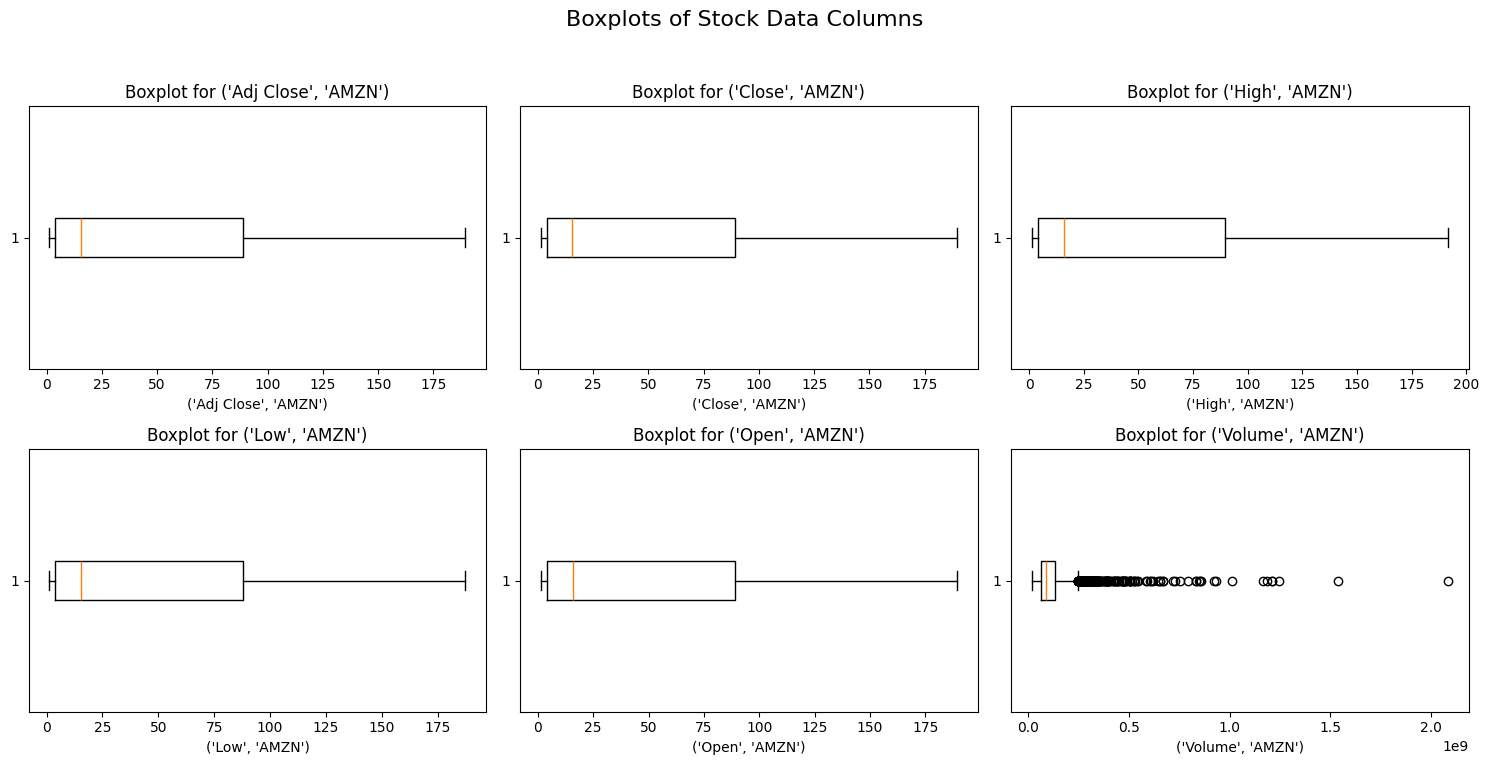

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Giả sử stock_data là DataFrame của bạn
# Đảm bảo bạn đã import thư viện pandas và đã có dữ liệu

# Tạo subplot
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
fig.suptitle('Boxplots of Stock Data Columns', fontsize=16)

# Duyệt qua từng cột và vẽ biểu đồ boxplot
for i, column in enumerate(stock_data.columns):
    row, col = divmod(i, 3)
    axs[row, col].boxplot(stock_data[column], vert=False)
    axs[row, col].set_title(f'Boxplot for {column}')
    axs[row, col].set_xlabel(column)

# Tự điều chỉnh khoảng cách giữa các subplot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Hiển thị biểu đồ
plt.show()

3. Biểu đồ Heatmap

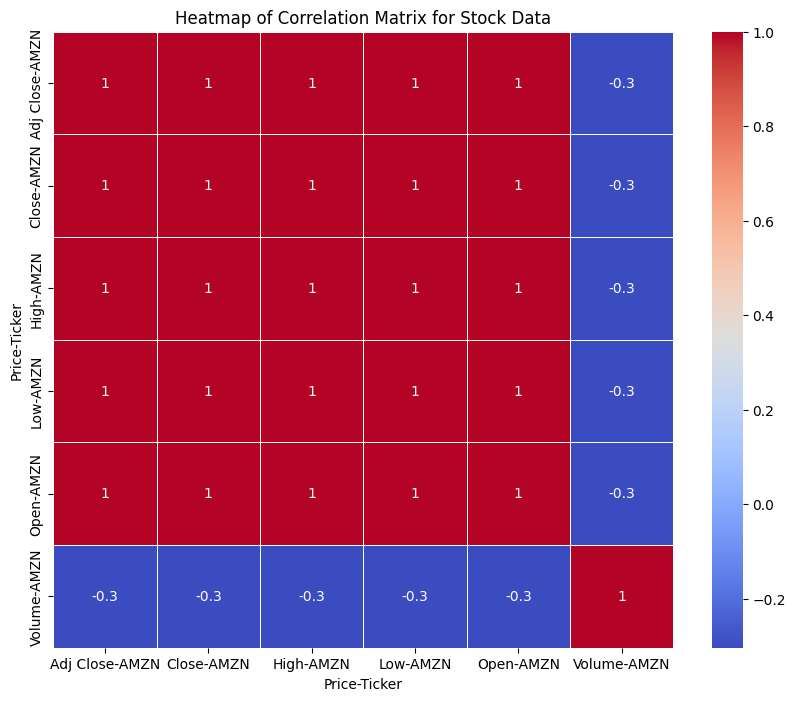

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Giả sử stock_data là DataFrame của bạn
# Đảm bảo bạn đã import thư viện pandas và seaborn và đã có dữ liệu

# Tạo heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(stock_data.corr(), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Heatmap of Correlation Matrix for Stock Data')
plt.show()

4. Biểu đồ scatter

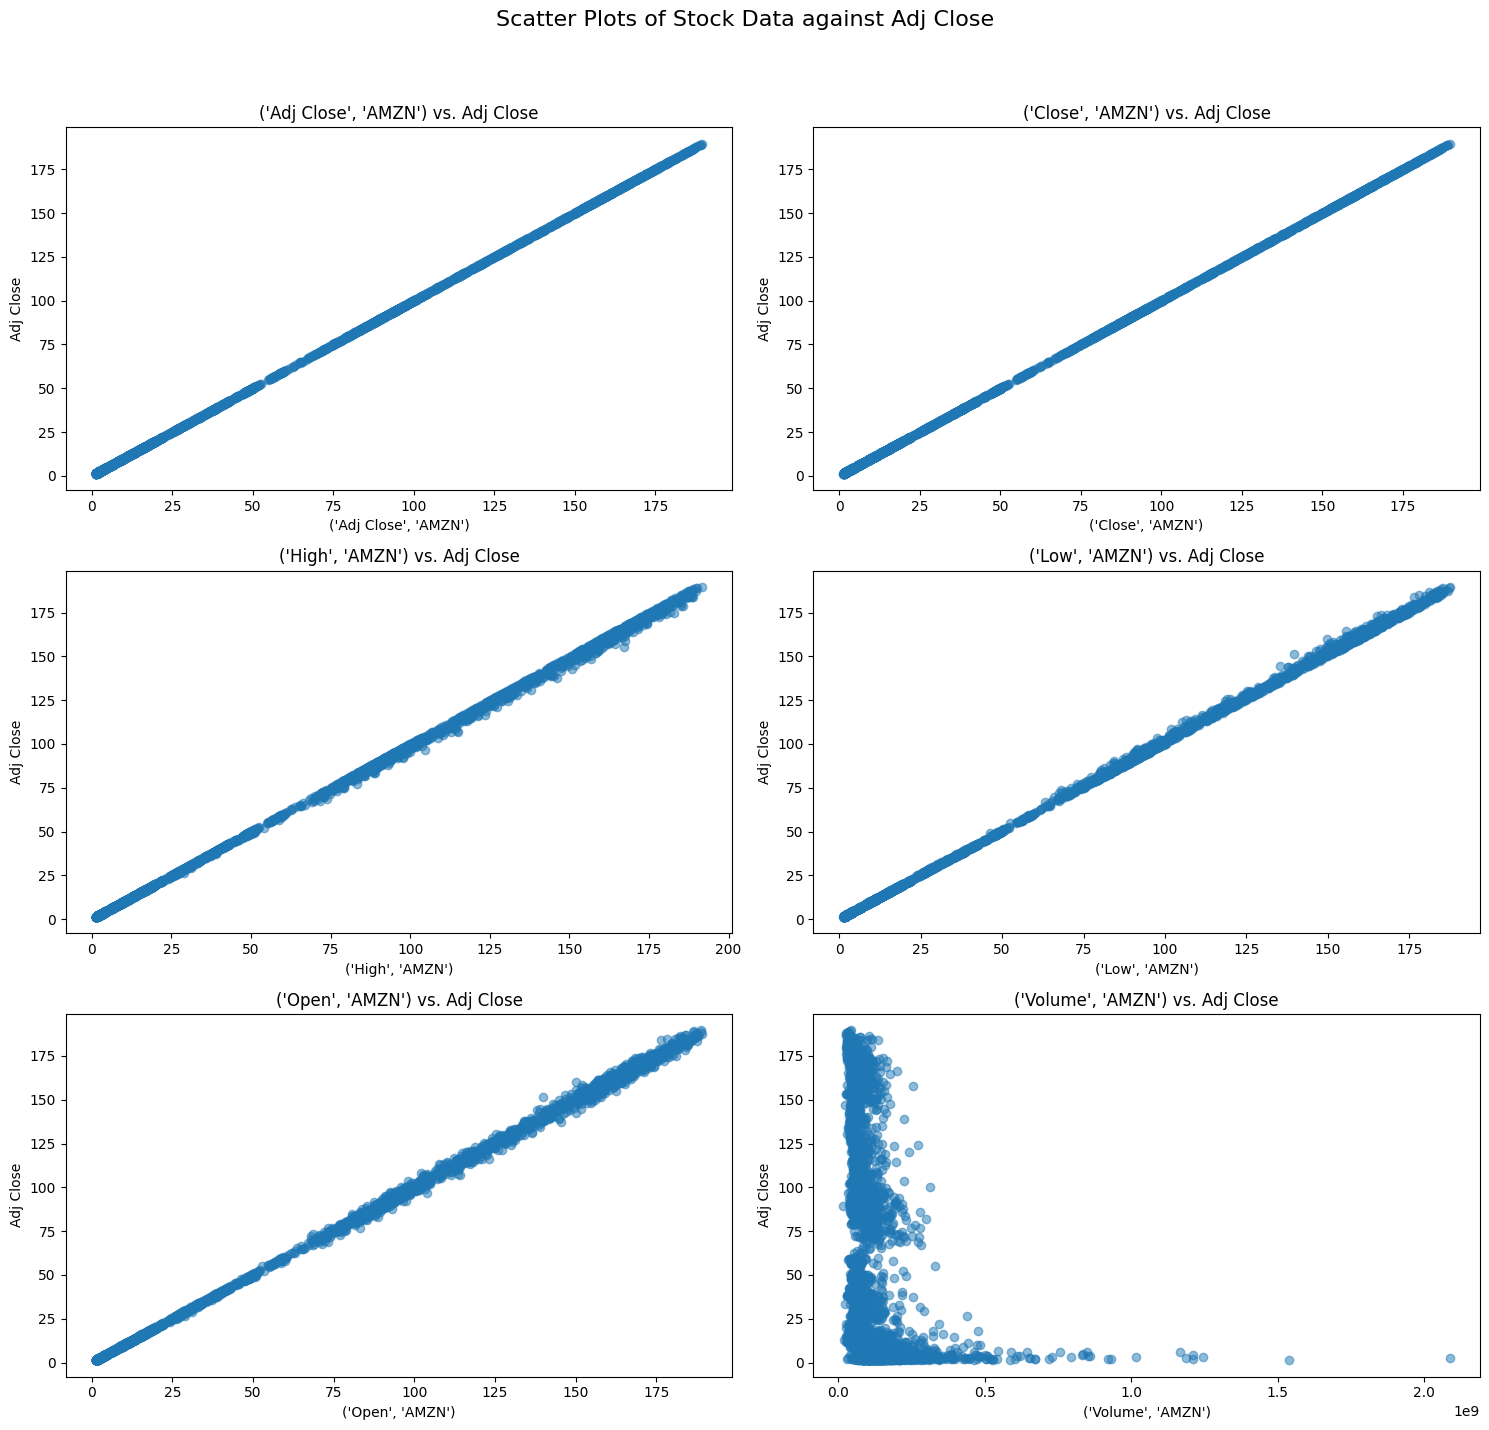

In [21]:
# Tính toán số lượng cột và số lượng hàng dựa vào số cột trong DataFrame
num_cols = len(stock_data.columns)
num_rows = (num_cols + 1) // 2  # Số hàng làm tròn lên nếu có số lẻ cột

# Tạo subplot
fig, axs = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, 5 * num_rows))
fig.suptitle('Scatter Plots of Stock Data against Adj Close', fontsize=16)

# Duyệt qua từng cột và vẽ biểu đồ scatter
for i, column in enumerate(stock_data.columns):
    row, col = divmod(i, 2)
    axs[row, col].scatter(stock_data[column], stock_data['Adj Close'], alpha=0.5)
    axs[row, col].set_title(f'{column} vs. Adj Close')
    axs[row, col].set_xlabel(column)
    axs[row, col].set_ylabel('Adj Close')

# Hiển thị biểu đồ
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Thông qua biểu đồ heatmap và biểu đồ scatter, ta thấy sự phụ thuộc tuyến tính giữa cột Adj close với các cột Open, Hight, Low, Close.
Vì thế nên ta sẽ chia tập X, Y như sau:

In [22]:
# Chọn cột 'Adj Close' (giá đóng cửa đã điều chỉnh) làm biến phụ thuộc (Y)
Y = stock_data['Adj Close']
Y

Ticker,AMZN
Date,
2003-10-20 00:00:00+00:00,2.979500
2003-10-21 00:00:00+00:00,2.967500
2003-10-22 00:00:00+00:00,2.701500
2003-10-23 00:00:00+00:00,2.716000
2003-10-24 00:00:00+00:00,2.725500
...,...
2024-06-07 00:00:00+00:00,184.300003
2024-06-10 00:00:00+00:00,187.059998
2024-06-11 00:00:00+00:00,187.229996


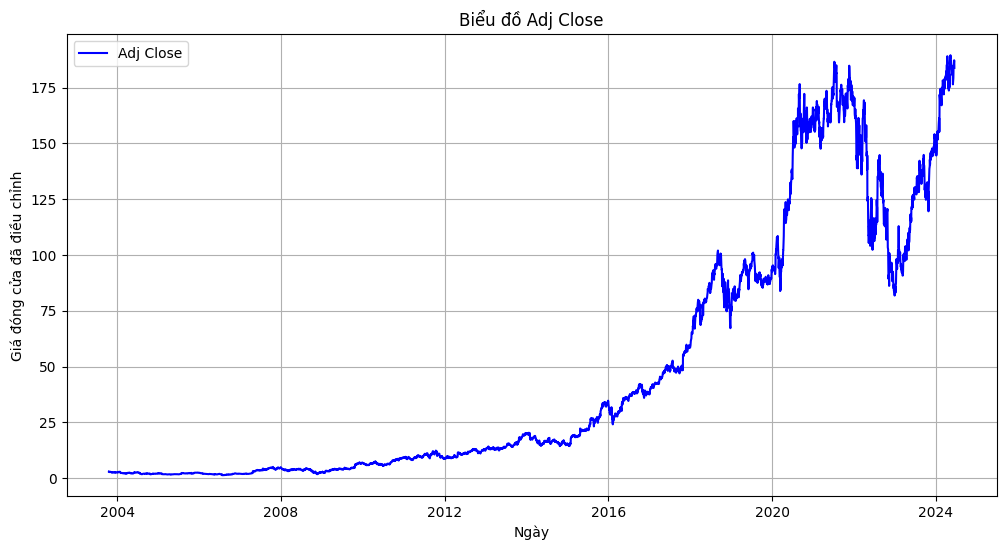

In [23]:
# Vẽ biểu đồ đường cho cột 'Adj Close'
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, Y, label='Adj Close', color='blue')
plt.title('Biểu đồ Adj Close')
plt.xlabel('Ngày')
plt.ylabel('Giá đóng cửa đã điều chỉnh')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Chọn các cột trừ cột 'Adj Close' và 'Volume làm biến độc lập (X)
X = stock_data.drop(columns=['Adj Close','Volume'])
X

Price,Close,High,Low,Open
Ticker,AMZN,AMZN,AMZN,AMZN
Date,,,,
2003-10-20 00:00:00+00:00,2.979500,3.012000,2.946000,2.978000
2003-10-21 00:00:00+00:00,2.967500,3.057500,2.950500,2.986500
2003-10-22 00:00:00+00:00,2.701500,2.807500,2.686500,2.802500
2003-10-23 00:00:00+00:00,2.716000,2.726000,2.645500,2.649000
2003-10-24 00:00:00+00:00,2.725500,2.747000,2.650000,2.727500
...,...,...,...,...
2024-06-07 00:00:00+00:00,184.300003,186.289993,183.360001,184.899994
2024-06-10 00:00:00+00:00,187.059998,187.229996,183.789993,184.070007


Thay vì sử dụng chỉ số (index) là số thứ tự thì ta sẽ dùng ngày tháng. Do không ảnh hưởng đến việc huấn luyện nên ta không cần chuyển về dạng số thứ tự.

In [25]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [26]:
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("Y_train: ", Y_train.shape)
print("Y_test: ", Y_test.shape)
#kiểm tra độ lớn của dữ liệu sau khi chia

X_train:  (4158, 4)
X_test:  (1040, 4)
Y_train:  (4158, 1)
Y_test:  (1040, 1)


In [27]:
X_train

Price,Close,High,Low,Open
Ticker,AMZN,AMZN,AMZN,AMZN
Date,,,,
2011-10-04 00:00:00+00:00,10.625000,10.750000,10.021500,10.481000
2018-06-21 00:00:00+00:00,86.511002,88.154999,85.877998,88.000000
2017-04-27 00:00:00+00:00,45.918999,46.092999,45.605499,45.719501
2018-03-26 00:00:00+00:00,77.792999,77.849503,74.962502,76.500000
2004-12-03 00:00:00+00:00,2.004500,2.023000,1.977000,2.018000
...,...,...,...,...
2005-08-25 00:00:00+00:00,2.115500,2.140000,2.104000,2.127000
2016-02-02 00:00:00+00:00,27.605000,28.577999,27.504499,28.500000


In [28]:
X_test

Price,Close,High,Low,Open
Ticker,AMZN,AMZN,AMZN,AMZN
Date,,,,
2009-02-06 00:00:00+00:00,3.327500,3.350000,3.159000,3.159000
2004-02-12 00:00:00+00:00,2.353000,2.405000,2.335500,2.346500
2016-09-27 00:00:00+00:00,40.805500,40.832001,40.055500,40.092499
2010-03-09 00:00:00+00:00,6.441000,6.540500,6.398500,6.479500
2022-03-17 00:00:00+00:00,157.238998,157.498505,152.139999,152.640503
...,...,...,...,...
2008-06-20 00:00:00+00:00,4.055000,4.173000,4.025500,4.155000
2007-06-27 00:00:00+00:00,3.407000,3.410500,3.335500,3.348000


In [29]:
Y_train

Ticker,AMZN
Date,
2011-10-04 00:00:00+00:00,10.625000
2018-06-21 00:00:00+00:00,86.511002
2017-04-27 00:00:00+00:00,45.918999
2018-03-26 00:00:00+00:00,77.792999
2004-12-03 00:00:00+00:00,2.004500
...,...
2005-08-25 00:00:00+00:00,2.115500
2016-02-02 00:00:00+00:00,27.605000
2018-10-12 00:00:00+00:00,89.430496


In [30]:
Y_test

Ticker,AMZN
Date,
2009-02-06 00:00:00+00:00,3.327500
2004-02-12 00:00:00+00:00,2.353000
2016-09-27 00:00:00+00:00,40.805500
2010-03-09 00:00:00+00:00,6.441000
2022-03-17 00:00:00+00:00,157.238998
...,...
2008-06-20 00:00:00+00:00,4.055000
2007-06-27 00:00:00+00:00,3.407000
2013-09-09 00:00:00+00:00,14.985500


Ta hãy lưu mô hình chuẩn hóa sau vào 1 file, để sau này chúng ta sẽ chuẩn hóa dữ liệu nhập vào theo file này( lưu chuẩn hóa của X vì dữ liệu chúng ta nhập vào là tập dữ liệu X, tức đầu vào)

In [31]:
from sklearn.preprocessing import MinMaxScaler
minmax_scale = MinMaxScaler()
X_train = minmax_scale.fit_transform(X_train)
import pickle
with open("/content/drive/MyDrive/PhanVanKiet_Scaler/Scaler_Amazon.pkl", "wb") as file:
    pickle.dump(minmax_scale, file)
X_test = minmax_scale.transform(X_test)

In [32]:
X_train, X_train.shape

(array([[0.04953068, 0.04955748, 0.04691596, 0.04884872],
        [0.45275816, 0.45612837, 0.45441358, 0.46150099],
        [0.2370687 , 0.2351971 , 0.23807157, 0.23643173],
        ...,
        [0.46827118, 0.46816978, 0.46112049, 0.47427677],
        [0.95632224, 0.94642437, 0.95331771, 0.95177146],
        [0.00356542, 0.00352444, 0.00353206, 0.00356391]]),
 (4158, 4))

In [33]:
X_test, X_test.shape

(array([[0.01075472, 0.01068887, 0.01005093, 0.00987195],
        [0.00557662, 0.00572524, 0.00562712, 0.00554682],
        [0.20989763, 0.20756363, 0.20825723, 0.20647784],
        ...,
        [0.07270061, 0.07187016, 0.072747  , 0.07216451],
        [0.0070166 , 0.00691231, 0.00644903, 0.00636926],
        [0.82147914, 0.81622762, 0.82204328, 0.81829114]]),
 (1040, 4))

**Bước 3: Huấn luyện mô hình**

In [34]:
# Mô hình hồi quy tuyến tính
model = LinearRegression()
model.fit(X_train, Y_train) # fit chính là hàm đào tạo

LinearRegression()

**Bước 4: Đánh giá mô hình**

In [35]:
from sklearn.metrics import mean_squared_error, r2_score
#mean_squared_error càng thấp(về 0) càng tốt
#r2_score càng cao càng tốt

In [36]:
Y_pred = model.predict(X_test) #dự báo Y_pred dựa trên tập X_test
Y_pred_train = model.predict(X_train)
# Đánh giá mô hình bằng một số các metric, gói gọn vào 1 hàm để sử dụng ở phần sau
def rate(Y_test, Y_pred, Y_train, Y_pred_train):
    print('--------Kết quả trên dữ liệu huấn luyện-------')
    mse_train = mean_squared_error(Y_train, Y_pred_train)
    r2_train = r2_score(Y_train, Y_pred_train)

    print("Mean Squared Error (MSE):", mse_train)
    print("R-squared (R2) Score:", r2_train)

    print('--------Kết quả thẩm định-------')
    mse = mean_squared_error(Y_test, Y_pred)
    r2 = r2_score(Y_test, Y_pred)

    print("Mean Squared Error (MSE):", mse)
    print("R-squared (R2) Score:", r2)

In [37]:
Y_pred.shape

(1040, 1)

In [38]:
Y_test.shape

(1040, 1)

In [39]:
rate(Y_test, Y_pred, Y_train, Y_pred_train)

--------Kết quả trên dữ liệu huấn luyện-------
Mean Squared Error (MSE): 8.88917123024434e-28
R-squared (R2) Score: 1.0
--------Kết quả thẩm định-------
Mean Squared Error (MSE): 9.102337925401498e-28
R-squared (R2) Score: 1.0


In [40]:
print(Y_test)

Ticker                           AMZN
Date                                 
2009-02-06 00:00:00+00:00    3.327500
2004-02-12 00:00:00+00:00    2.353000
2016-09-27 00:00:00+00:00   40.805500
2010-03-09 00:00:00+00:00    6.441000
2022-03-17 00:00:00+00:00  157.238998
...                               ...
2008-06-20 00:00:00+00:00    4.055000
2007-06-27 00:00:00+00:00    3.407000
2013-09-09 00:00:00+00:00   14.985500
2003-12-23 00:00:00+00:00    2.624000
2020-11-24 00:00:00+00:00  155.903000

[1040 rows x 1 columns]


In [41]:
print(Y_pred)

[[  3.3275001 ]
 [  2.35299993]
 [ 40.80550003]
 ...
 [ 14.98550034]
 [  2.62400007]
 [155.90299988]]


In [43]:
Y_test = Y_test.values.ravel()  # Hoặc Y_test = Y_test.flatten()
Y_pred = Y_pred.ravel()  # Hoặc Y_pred = Y_pred.flatten()

df_result = pd.DataFrame({'Actual':Y_test, 'Predicted': Y_pred})
df_compare = df_result.head(10)
df_compare
#so sánh dữ liệu thực tế với dự đoán

,Actual,Predicted
0,3.327500,3.327500
1,2.353000,2.353000
2,40.805500,40.805500
3,6.441000,6.441000
4,157.238998,157.238998
5,88.999496,88.999496
6,9.250500,9.250500
7,14.896000,14.896000
8,1.533500,1.533500
9,9.229500,9.229500


<Axes: >

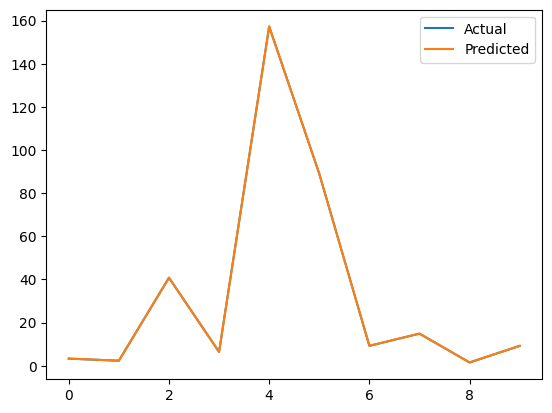

In [44]:
df_compare.plot(kind='line')
# lập biểu đồ độ để dễ đánh giá

**Ta thấy mô hình quá tốt.**

**Bước 5: Lưu mô hình**

In [45]:
import pickle
# Lưu mô hình vào tệp
with open("/content/drive/MyDrive/PhanVanKiet_Model/Model_Amazon.pkl", "wb") as model_file:
    pickle.dump(model, model_file)